In [18]:
# Load the packages that are required
import numpy as np
import operator
import matplotlib.pyplot as plt

import sys
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')
import math
# Qiskit packages
# from qiskit_textbook.tools import vector2latex
from qiskit.quantum_info import Statevector
from qiskit.transpiler.passes import Unroller
from qiskit import BasicAer, QuantumCircuit, ClassicalRegister, QuantumRegister, IBMQ, Aer, assemble, transpile, execute
from qiskit.quantum_info import Pauli, Statevector
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.circuit.library import TwoLocal
# import qiskit.providers.aer as Some
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.algorithms.optimizers import SPSA
# for mocks
import qiskit.test.mock as mok
from qiskit.test.mock import FakeMelbourne as Mback


In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from QPSA import (
    initialize_s,
    initialize_Gq,
    diffuser,
    partial_diffuser,
    oracle,
    grover_operator,
    local_grover_operator,
    design_grover_circuit,
    design_partial_grover_circuit,
    classic_grover_stats,
    QPSA_stats,
    design_and_test_two_stage,
    multi_controlled_toffoli
)
from RunTests import ThreeQubitCases, OtherCases, test_experiment_expected_depth, test_experiment_actual_probability
from NoiseModels import NoiseModels
import RunTests as testies
import NoiseModels as noisies

In [24]:
# Creating simulators with different noise models
device_backend = Mback()
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
basis_gates = NoiseModels(1).initialize_thermal_noise().basis_gates
testers = []
noise_consts = list([x/10 for x in range(6, 20)])
for i in noise_consts:
    noise_constant = i
    NM = NoiseModels(noise_constant)
    noise_model = NM.initialize_thermal_noise()
    backend = QasmSimulator(method='density_matrix',
                                noise_model=noise_model)
    execution_params = (coupling_map, basis_gates, noise_model)
    testers+=[OtherCases(backend, execution_params)]

        
Len = len(testers)
    
def test_experiment_expected_depth(experiment):
    results = []
    for i in range(Len):
        print("NOISE CONSTANT:", noise_consts[i])
        res = experiment(testers[i])
        results += [res[5]]
    return results


def test_experiment_actual_probability(experiment):
    results = []
    for i in range(Len):
        print("NOISE CONSTANT:", noise_consts[i])
        res = experiment(testers[i])
        results += [res[2]]
    return results

# Real tests on 6 qubits
ress_D6_1M6 = test_experiment_expected_depth((lambda test_class: testies._D6_iM6(test_class, 1)))
ress_D6_2M6 = test_experiment_expected_depth((lambda test_class: testies._D6_iM6(test_class, 2)))
ress_D4_1M6 = test_experiment_expected_depth((lambda test_class: testies._D4_iM6(test_class, 1)))
ress_D4_2M6 = test_experiment_expected_depth((lambda test_class: testies._D4_iM6(test_class, 2)))
ress_D4_3M6 = test_experiment_expected_depth((lambda test_class: testies._D4_iM6(test_class, 3)))
ress_D4_1M2_D4_1M4 = test_experiment_expected_depth((lambda test_class: testies._D4_i1M2_D4_i2M4(test_class, 1, 1)))
ress_D4_2M2_D4_2M4 = test_experiment_expected_depth((lambda test_class: testies._D4_i1M2_D4_i2M4(test_class, 2, 2)))

NOISE CONSTANT: 0.6
Test D6_1M6: __________________
gates =  OrderedDict([('u3', 200), ('cx', 184), ('measure', 6), ('u2', 1)])
NOISE CONSTANT: 0.7
Test D6_1M6: __________________
gates =  OrderedDict([('u3', 200), ('cx', 184), ('measure', 6), ('u2', 1)])
NOISE CONSTANT: 0.8
Test D6_1M6: __________________
gates =  OrderedDict([('u3', 200), ('cx', 184), ('measure', 6), ('u2', 1)])
NOISE CONSTANT: 0.9
Test D6_1M6: __________________
gates =  OrderedDict([('u3', 200), ('cx', 184), ('measure', 6), ('u2', 1)])
NOISE CONSTANT: 1.0
Test D6_1M6: __________________
gates =  OrderedDict([('u3', 200), ('cx', 184), ('measure', 6), ('u2', 1)])
NOISE CONSTANT: 1.1
Test D6_1M6: __________________
gates =  OrderedDict([('u3', 200), ('cx', 184), ('measure', 6), ('u2', 1)])
NOISE CONSTANT: 1.2
Test D6_1M6: __________________
gates =  OrderedDict([('u3', 200), ('cx', 184), ('measure', 6), ('u2', 1)])
NOISE CONSTANT: 1.3
Test D6_1M6: __________________
gates =  OrderedDict([('u3', 200), ('cx', 184), ('me

gates =  OrderedDict([('u3', 337), ('cx', 318), ('measure', 6), ('u2', 1)])
NOISE CONSTANT: 1.5
Test D6_3M6: __________________
gates =  OrderedDict([('u3', 337), ('cx', 318), ('measure', 6), ('u2', 1)])
NOISE CONSTANT: 1.6
Test D6_3M6: __________________
gates =  OrderedDict([('u3', 337), ('cx', 318), ('measure', 6), ('u2', 1)])
NOISE CONSTANT: 1.7
Test D6_3M6: __________________
gates =  OrderedDict([('u3', 337), ('cx', 318), ('measure', 6), ('u2', 1)])
NOISE CONSTANT: 1.8
Test D6_3M6: __________________
gates =  OrderedDict([('u3', 337), ('cx', 318), ('measure', 6), ('u2', 1)])
NOISE CONSTANT: 1.9
Test D6_3M6: __________________
gates =  OrderedDict([('u3', 337), ('cx', 318), ('measure', 6), ('u2', 1)])
NOISE CONSTANT: 0.6
Test D4_1M2_D4_1M4: __________________
NOISE CONSTANT: 0.7
Test D4_1M2_D4_1M4: __________________
NOISE CONSTANT: 0.8
Test D4_1M2_D4_1M4: __________________
NOISE CONSTANT: 0.9
Test D4_1M2_D4_1M4: __________________
NOISE CONSTANT: 1.0
Test D4_1M2_D4_1M4: ________

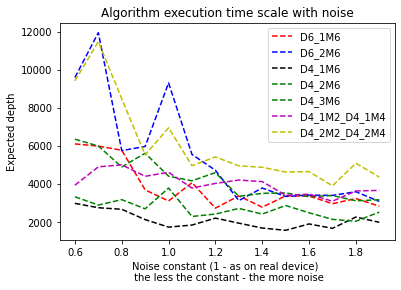

In [25]:
fig, ax = plt.subplots()
ax.set_ylabel('Expected depth')
ax.set_xlabel('Noise constant (1 - as on real device) \n the less the constant - the more noise')
ax.set_title('Algorithm execution time scale with noise')

plt.plot(noise_consts, ress_D6_1M6, 'r--', label='D6_1M6')
plt.plot(noise_consts, ress_D6_2M6, 'b--', label='D6_2M6')
plt.plot(noise_consts, ress_D4_1M6, 'k--', label='D4_1M6')
plt.plot(noise_consts, ress_D4_2M6, 'g--', label='D4_2M6')
plt.plot(noise_consts, ress_D4_3M6, 'g--', label='D4_3M6')
plt.plot(noise_consts, ress_D4_1M2_D4_1M4, 'm--', label='D4_1M2_D4_1M4')
plt.plot(noise_consts, ress_D4_2M2_D4_2M4, 'y--', label='D4_2M2_D4_2M4')
plt.legend()
plt.show()

In [32]:
# tests on 8qubits
testers = []
noise_consts = list([x/5 for x in range(3, 10)])
for i in noise_consts:
    noise_constant = i
    NM = NoiseModels(noise_constant)
    noise_model = NM.initialize_thermal_noise()
    backend = QasmSimulator(method='density_matrix',
                                noise_model=noise_model)
    execution_params = (coupling_map, basis_gates, noise_model)
    testers+=[OtherCases(backend, execution_params)]

Len = len(testers)

ress_D8_1M8 = test_experiment_expected_depth((lambda test_class: testies._D8_iM8(test_class, 1)))
ress_D8_2M8 = test_experiment_expected_depth((lambda test_class: testies._D8_iM8(test_class, 2)))

ress_D6_1M8 = test_experiment_expected_depth((lambda test_class: testies._D6_iM8(test_class, 1)))
ress_D6_2M8 = test_experiment_expected_depth((lambda test_class: testies._D6_iM8(test_class, 2)))

ress_G1D6_1M8 = test_experiment_expected_depth((lambda test_class: testies._G1D6_iM8(test_class, 1)))
ress_G1D6_2M8 = test_experiment_expected_depth((lambda test_class: testies._G1D6_iM8(test_class, 2)))

ress_G1D7_1M8 = test_experiment_expected_depth((lambda test_class: testies._G1D7_iM8(test_class, 1)))
ress_G1D7_2M8 = test_experiment_expected_depth((lambda test_class: testies._G1D7_iM8(test_class, 2)))

# to other category
ress_G2D6_1M8 = test_experiment_expected_depth((lambda test_class: testies._G2D6_iM8(test_class, 1)))
ress_G2D6_2M8 = test_experiment_expected_depth((lambda test_class: testies._G2D6_iM8(test_class, 2)))

NOISE CONSTANT: 0.6
Test D8_1M8: __________________
NOISE CONSTANT: 0.8
Test D8_1M8: __________________
NOISE CONSTANT: 1.0
Test D8_1M8: __________________
NOISE CONSTANT: 1.2
Test D8_1M8: __________________
NOISE CONSTANT: 1.4
Test D8_1M8: __________________
NOISE CONSTANT: 1.6
Test D8_1M8: __________________
NOISE CONSTANT: 1.8
Test D8_1M8: __________________
NOISE CONSTANT: 0.6
Test D8_2M8: __________________
NOISE CONSTANT: 0.8
Test D8_2M8: __________________
NOISE CONSTANT: 1.0
Test D8_2M8: __________________
NOISE CONSTANT: 1.2
Test D8_2M8: __________________
NOISE CONSTANT: 1.4
Test D8_2M8: __________________
NOISE CONSTANT: 1.6
Test D8_2M8: __________________
NOISE CONSTANT: 1.8
Test D8_2M8: __________________
NOISE CONSTANT: 0.6
Test D6_1M8: __________________
NOISE CONSTANT: 0.8
Test D6_1M8: __________________
NOISE CONSTANT: 1.0
Test D6_1M8: __________________
NOISE CONSTANT: 1.2
Test D6_1M8: __________________
NOISE CONSTANT: 1.4
Test D6_1M8: __________________
NOISE CONSTA

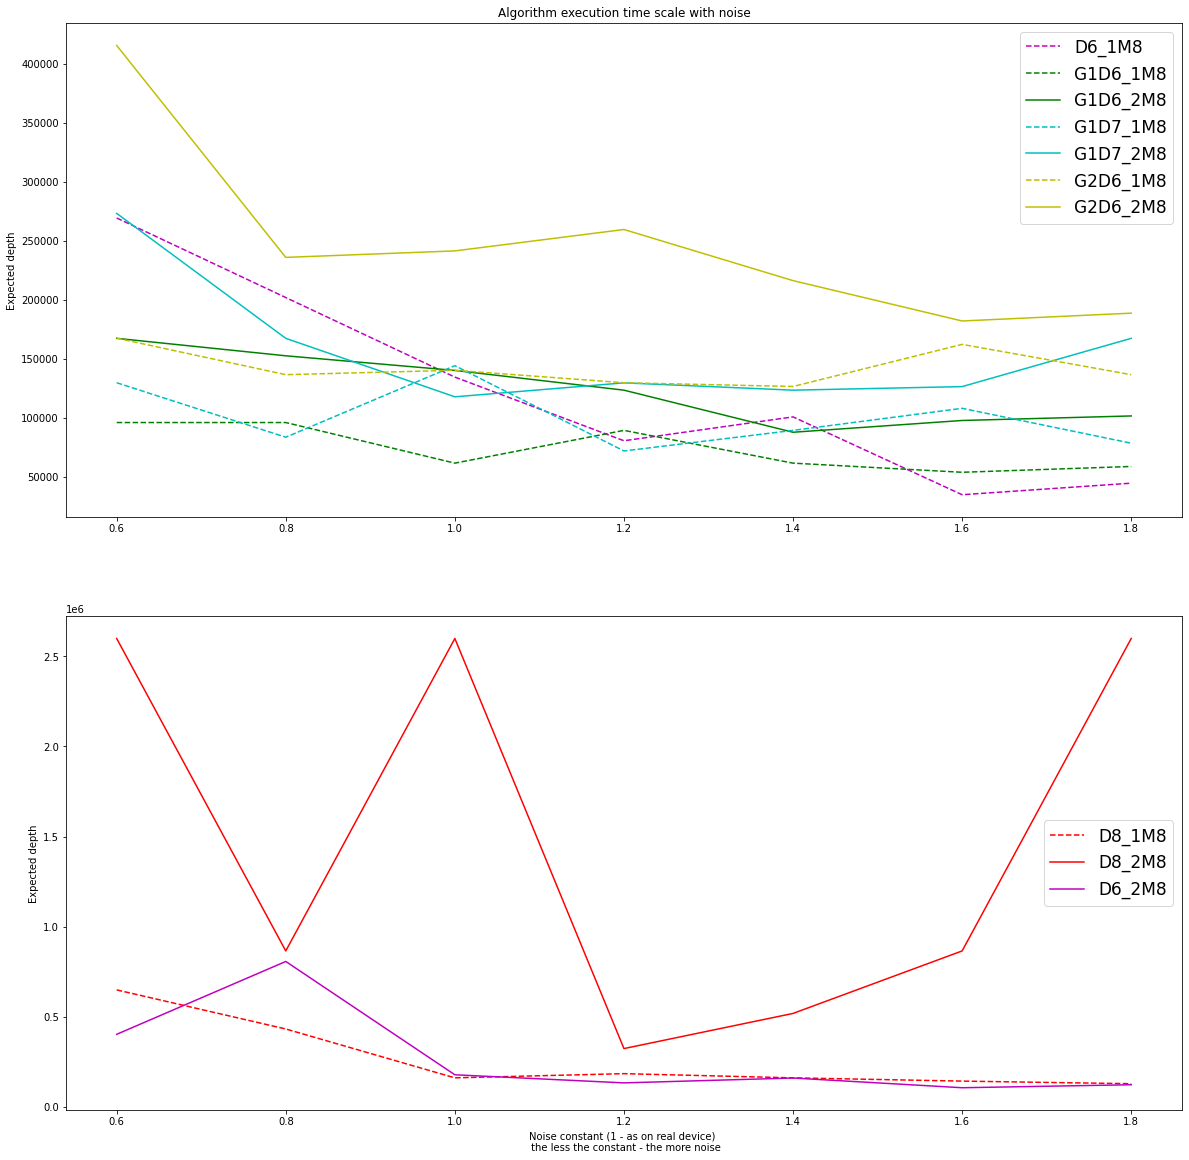

In [81]:
# fig, ax = plt.subplots(2)
# plt.figure(figsize=(6, 6))
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
ax = [None, None]
# Adds subplot on position 1
ax[0] = fig.add_subplot(211)
# Adds subplot on position 2
ax[1] = fig.add_subplot(212, sharex = ax[0])

ax[0].set_ylabel('Expected depth')
ax[1].set_ylabel('Expected depth')
ax[1].set_xlabel('Noise constant (1 - as on real device) \n the less the constant - the more noise')
ax[0].set_title('Algorithm execution time scale with noise')

# some numbers are too big, so it would be convenient to show them on another graph 

ax[1].plot(noise_consts, ress_D8_1M8, 'r--', label='D8_1M8')
ax[1].plot(noise_consts, ress_D8_2M8, 'r', label='D8_2M8')

ax[0].plot(noise_consts, ress_D6_1M8, 'm--', label='D6_1M8')
ax[1].plot(noise_consts, ress_D6_2M8, 'm', label='D6_2M8')

ax[0].plot(noise_consts, ress_G1D6_1M8, 'g--', label='G1D6_1M8')
ax[0].plot(noise_consts, ress_G1D6_2M8, 'g', label='G1D6_2M8')

ax[0].plot(noise_consts, ress_G1D7_1M8, 'c--', label='G1D7_1M8')
ax[0].plot(noise_consts, ress_G1D7_2M8, 'c', label='G1D7_2M8')

ax[0].plot(noise_consts, ress_G2D6_1M8, 'y--', label='G2D6_1M8')
ax[0].plot(noise_consts, ress_G2D6_2M8, 'y', label='G2D6_2M8')

ax[0].legend(prop={'size': 17})
ax[1].legend(prop={'size': 17})
plt.show()

In [82]:
# tests on 10 qubits
# depends on the processor it could take about 14:06
testers = []
noise_consts = list([x/5 for x in range(3, 10)])
for i in noise_consts:
    noise_constant = i
    NM = NoiseModels(noise_constant)
    noise_model = NM.initialize_thermal_noise()
    backend = QasmSimulator(method='density_matrix',
                                noise_model=noise_model)
    execution_params = (coupling_map, basis_gates, noise_model)
    testers+=[OtherCases(backend, execution_params)]

Len = len(testers)

ress_D10_1M10 = test_experiment_expected_depth((lambda test_class: testies._D10_iM10(test_class, 1)))
ress_D10_2M10 = test_experiment_expected_depth((lambda test_class: testies._D10_iM10(test_class, 2)))

ress_D8_1M10 = test_experiment_expected_depth((lambda test_class: testies._D8_iM10(test_class, 1)))
ress_D8_2M10 = test_experiment_expected_depth((lambda test_class: testies._D8_iM10(test_class, 2)))


NOISE CONSTANT: 0.6
Test D10_1M10: __________________
NOISE CONSTANT: 0.8
Test D10_1M10: __________________
NOISE CONSTANT: 1.0
Test D10_1M10: __________________
NOISE CONSTANT: 1.2
Test D10_1M10: __________________
NOISE CONSTANT: 1.4
Test D10_1M10: __________________
NOISE CONSTANT: 1.6
Test D10_1M10: __________________
NOISE CONSTANT: 1.8
Test D10_1M10: __________________
NOISE CONSTANT: 0.6
Test D10_2M10: __________________
NOISE CONSTANT: 0.8
Test D10_2M10: __________________
NOISE CONSTANT: 1.0
Test D10_2M10: __________________
NOISE CONSTANT: 1.2
Test D10_2M10: __________________
NOISE CONSTANT: 1.4
Test D10_2M10: __________________
NOISE CONSTANT: 1.6
Test D10_2M10: __________________
NOISE CONSTANT: 1.8
Test D10_2M10: __________________
NOISE CONSTANT: 0.6
Test D8_1M10: __________________
NOISE CONSTANT: 0.8
Test D8_1M10: __________________
NOISE CONSTANT: 1.0
Test D8_1M10: __________________
NOISE CONSTANT: 1.2
Test D8_1M10: __________________
NOISE CONSTANT: 1.4
Test D8_1M10

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "D:\anacond\envs\BaseJupyter\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\пк\AppData\Local\Temp\ipykernel_4868\2003667048.py", line 19, in <cell line: 19>
    ress_D8_2M10 = test_experiment_expected_depth((lambda test_class: testies._D8_iM10(test_class, 2)))
  File "C:\Users\пк\AppData\Local\Temp\ipykernel_4868\1479243095.py", line 22, in test_experiment_expected_depth
    res = experiment(testers[i])
  File "C:\Users\пк\AppData\Local\Temp\ipykernel_4868\2003667048.py", line 19, in <lambda>
    ress_D8_2M10 = test_experiment_expected_depth((lambda test_class: testies._D8_iM10(test_class, 2)))
  File "D:\desktoptop\QUANTA\QPSA\RunTests.py", line 180, in _D8_iM10
    return test_class.D8_iM10(i)
  File "D:\desktoptop\QUANTA\QPSA\RunTests.py", line 137, in D8_iM10
    return print_result(result)
  File "D:\desktoptop\QUANTA\QPSA\RunTests.py", line

NameError: name 'ress_D8_2M10' is not defined

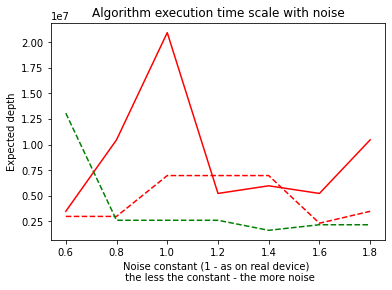

In [83]:
fig, ax = plt.subplots()
ax.set_ylabel('Expected depth')
ax.set_xlabel('Noise constant (1 - as on real device) \n the less the constant - the more noise')
ax.set_title('Algorithm execution time scale with noise')

plt.plot(noise_consts, ress_D10_1M10, 'r--', label='D10_1M10')
plt.plot(noise_consts, ress_D10_2M10, 'r', label='D10_2M10')
plt.plot(noise_consts, ress_D8_1M10, 'g--', label='D8_1M10')
plt.plot(noise_consts, ress_D8_2M10, 'g', label='D8_2M10')


# здесь у алгоритма D8_2M10 вероятность оказалась просто нулевая
plt.legend()
plt.show()

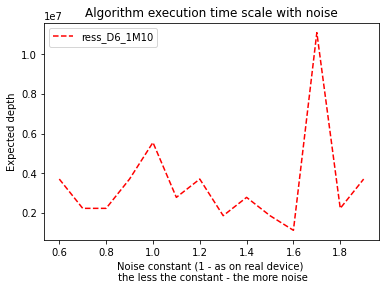

In [35]:
fig, ax = plt.subplots()
ax.set_ylabel('Expected depth')
ax.set_xlabel('Noise constant (1 - as on real device) \n the less the constant - the more noise')
ax.set_title('Algorithm execution time scale with noise')

plt.plot(noise_consts, ress_D6_1M10, 'r--', label='ress_D6_1M10')

plt.legend()
plt.show()

In [10]:
N = 1
var_qubits = QuantumRegister(3, name='q')
output_qubit = QuantumRegister(2, name='anc')  # additional qubit
qc = QuantumCircuit(var_qubits, output_qubit)

    # Apply transformation |s> -> |00..0> (H-gates)

    
qc.ccx(0, 3, 4)
qc.reset([3]*N)
qc.cx(4,3)
qc.reset([4]*N)

qc.ccx(1, 3, 4)
qc.reset([3]*N)
qc.cx(4,3)
qc.reset([4]*N)

qc.ccx(2, 3, 4)
qc.reset([3]*N)
qc.cx(4,3)
qc.reset([4]*N)

qc.draw()

q_0: ──■─────────────────────────────────────────────────────────
         │                                                         
  q_1: ──┼───────────────────■─────────────────────────────────────
         │                   │                                     
  q_2: ──┼───────────────────┼───────────────────■─────────────────
         │       ┌───┐       │       ┌───┐       │       ┌───┐     
anc_0: ──■───|0>─┤ X ├───────■───|0>─┤ X ├───────■───|0>─┤ X ├─────
       ┌─┴─┐     └─┬─┘     ┌─┴─┐     └─┬─┘     ┌─┴─┐     └─┬─┘     
anc_1: ┤ X ├───────■───|0>─┤ X ├───────■───|0>─┤ X ├───────■───|0>─
       └───┘               └───┘               └───┘

In [56]:
# def both(N):
# #     N - number of resets in a single reset operation
#     qc = QuantumCircuit(3)
#     # Apply transformation |s> -> |00..0> (H-gates)
#     qc.ccx(0, 1, 2)
#     qc.reset([1]*N)
#     qc.cx(2,1)
#     qc.reset([2]*N)
#     # We will return the diffuser as a gate
# #     U_s = qc.to_gate()
#     qc.name = "Bc$"
#     return qc

# def multi_controlled_toffoli(n, N):
# #     (n-1) - number of controlled qubits
# #     N - number of resets in a single reset operation
#     qc = QuantumCircuit(n+2)
#     # Apply transformation |s> -> |00..0> (H-gates)
#     for i in range(n-1):
#         qc.append(both(N), [i,n,n+1])
#     qc.cx(n, n-1)
#     # We will return the diffuser as a gate
# #     U_s = qc.to_gate()
#     qc.name = "T$"
#     return qc

qc = QuantumCircuit(5)
qc.append(multi_controlled_toffoli(3,3), [0,1,2,3,4])
qc.draw()
optimized_3 = transpile(qc, backend=simulator, seed_transpiler=11, optimization_level=1)
print(optimized_3.depth())
# multi_controlled_toffoli(3, 3).draw()

# for i in range(3, 20):
#     print(i, " qubit case_____________")
#     optimized_3 = transpile(multi_controlled_toffoli(i,3), backend=simulator, seed_transpiler=11, optimization_level=1)
#     print("with reset: ", optimized_3.depth())
#     qc = QuantumCircuit(i)
#     qc.mct(list(range(i - 1)), i - 1)
#     optimized_3 = transpile(qc, backend=simulator, seed_transpiler=11, optimization_level=1)
#     print("without reset: ", optimized_3.depth())

60
3  qubit case_____________
with reset:  60
without reset:  19
4  qubit case_____________
with reset:  104
without reset:  42
5  qubit case_____________
with reset:  132
without reset:  129
6  qubit case_____________
with reset:  156
without reset:  281
7  qubit case_____________
with reset:  193
without reset:  547
8  qubit case_____________
with reset:  221
without reset:  1160
9  qubit case_____________
with reset:  254
without reset:  2430
10  qubit case_____________
with reset:  257
without reset:  4646
11  qubit case_____________
with reset:  272
without reset:  9242
12  qubit case_____________
with reset:  326


KeyboardInterrupt: 

In [44]:
i = 3
qc = QuantumCircuit(i)
qc.mct(list(range(i - 1)), i - 1)
qc.draw()

q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘

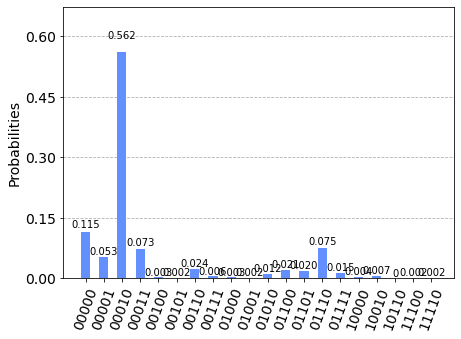

In [45]:
from qiskit.test.mock import FakeMelbourne
MB = FakeMelbourne()
backend = MB
qc = QuantumCircuit(5)
qc.initialize('00010', qc.qubits)
qc.append(multi_controlled_toffoli(3, 1), list(range(5)))
qc.measure_all()
optimized_3 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=3)
result = backend.run(optimized_3).result()
plot_histogram(result.get_counts(0))
# qc.draw()

In [14]:
nqubits = 3
qc = QuantumCircuit(nqubits)
# Apply transformation |s> -> |00..0> (H-gates)
for qubit in range(nqubits):
    qc.h(qubit)
# Apply transformation |00..0> -> |11..1> (X-gates)
for qubit in range(nqubits):
    qc.x(qubit)
# Do multi-controlled-Z gate
qc.h(nqubits - 1)
qc.mct(list(range(nqubits - 1)), nqubits - 1)  # multi-controlled-toffoli
qc.h(nqubits - 1)
# Apply transformation |11..1> -> |00..0>
for qubit in range(nqubits):
    qc.x(qubit)
# Apply transformation |00..0> -> |s>
for qubit in range(nqubits):
    qc.h(qubit)
qc.draw()

┌───┐┌───┐          ┌───┐┌───┐     
q_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘

In [16]:
n = 4
h = [1,0,0,1]
grover_circuit = QuantumCircuit(3, 2)
# grover_circuit = initialize_Gq(grover_circuit, [0,1,2,3], [0,1], 2)
grover_circuit.ccx(0, 1, 2)
optimized_3 = transpile(grover_circuit, backend=simulator, seed_transpiler=11, optimization_level=1)
print(optimized_3.depth())
optimized_3.draw()

17


global phase: 5π/8
                                                                           »
      q_0 -> 0 ────────────────────────────────────────────────────────────»
                                                                 ┌───┐     »
      q_1 -> 1 ──────────────────────────────■────────────────■──┤ X ├──■──»
               ┌─────────┐┌────┐┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─┬─┘┌─┴─┐»
      q_2 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ X ├┤ Rz(-π/4) ├┤ X ├──■──┤ X ├»
               └─────────┘└────┘└─────────┘└───┘└──────────┘└───┘     └───┘»
ancilla_0 -> 3 ────────────────────────────────────────────────────────────»
                                                                           »
ancilla_1 -> 4 ────────────────────────────────────────────────────────────»
                                                                           »
          c: 2/════════════════════════════════════════════════════════════»
                                                                           »
«                                                ┌───┐     ┌──────────┐»
«      q_0 -> 0 ──■──────────────────────────────┤ X ├──■──┤ Rz(3π/4) ├»
«               ┌─┴─┐┌─────────┐┌───┐┌──────────┐└─┬─┘┌─┴─┐└──────────┘»
«      q_1 -> 1 ┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├──■──┤ X ├─────■──────»
«               └───┘└─────────┘└─┬─┘├─────────┬┘     └───┘   ┌─┴─┐    »
«      q_2 -> 2 ──────────────────■──┤ Rz(π/4) ├──────────────┤ X ├────»
«                                    └─────────┘              └───┘    »
«ancilla_0 -> 3 ───────────────────────────────────────────────────────»
«                                                                      »
«ancilla_1 -> 4 ───────────────────────────────────────────────────────»
«                                                                      »
«          c: 2/═══════════════════════════════════════════════════════»
«                                                                      »
«                  ┌────┐   ┌─────────┐
«      q_0 -> 0 ───┤ √X ├───┤ Rz(π/2) ├
«               ┌──┴────┴─┐ └─────────┘
«      q_1 -> 1 ┤ Rz(π/4) ├──────■─────
«               ├─────────┴┐   ┌─┴─┐   
«      q_2 -> 2 ┤ Rz(-π/4) ├───┤ X ├───
«               └──────────┘   └───┘   
«ancilla_0 -> 3 ───────────────────────
«                                      
«ancilla_1 -> 4 ───────────────────────
«                                      
«          c: 2/═══════════════════════
«

In [22]:
from qiskit.test.mock import FakeProvider
provider = FakeProvider()
[ (b.name(), b.configuration().n_qubits) for b in provider.backends() if (b.configuration().n_qubits < 20 and b.configuration().n_qubits > 10)]

[('fake_guadalupe', 16), ('fake_melbourne', 14), ('fake_rueschlikon', 16)]

In [49]:

# from qiskit.test.mock import FakeVigo as Mback
# noise_model = NoiseModel.from_backend(Mback)
device_backend = Mback()

backend = Aer.get_backend('aer_simulator')
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
# noise_model = NoiseModel.from_backend(device)


noise_constant = 1

NM = NoiseModels(noise_constant)
# noise_model = NoiseModels.initialize_bit_flip_noise()
noise_model = NM.initialize_thermal_noise()

basis_gates = noise_model.basis_gates


backend = QasmSimulator(method='density_matrix',
                        noise_model=noise_model)

# circ = QuantumCircuit(3, 3)
# circ.h(0)
# circ.cx(0, 1)
# circ.cx(1, 2)
# circ.measure([0, 1, 2], [0, 1, 2])

# optimized_3 = transpile(circ, backend=backend, seed_transpiler=11, optimization_level=3)
# result = execute(optimized_3, backend,
#                  coupling_map=coupling_map,
#                  basis_gates=basis_gates,
#                  noise_model=noise_model).result()
# plot_histogram(result.get_counts(0))

execution_params = (coupling_map, basis_gates, noise_model)
test = ThreeQubitCases(backend, execution_params)
stress_test = OtherCases(backend, execution_params)
for i in range(1, 8):
    stress_test.D6_iM6(i)

Test D6_1M6: __________________
gates =  OrderedDict([('cx', 184), ('rz', 182), ('u3', 18), ('measure', 6), ('u2', 1)])
P_theoretical:  0.13482666015624925
P_actual:  0.087890625
selectivity:  3.9130434782608696
depth:  310
R_IBM:  0.6518786781349063
expected depth:  3527.1111111111113
Test D6_2M6: __________________
gates =  OrderedDict([('cx', 368), ('rz', 364), ('u3', 30), ('measure', 6), ('u2', 1)])
P_theoretical:  0.34389519691466947
P_actual:  0.1640625
selectivity:  7.0
depth:  618
R_IBM:  0.47707121667276076
expected depth:  3766.8571428571427
Test D6_3M6: __________________
gates =  OrderedDict([('cx', 552), ('rz', 546), ('u3', 42), ('measure', 6), ('u2', 1)])
P_theoretical:  0.5913801500573669
P_actual:  0.1484375
selectivity:  5.428571428571429
depth:  926
R_IBM:  0.25100183018588096
expected depth:  6238.315789473684
Test D6_4M6: __________________
gates =  OrderedDict([('cx', 736), ('rz', 728), ('u3', 54), ('measure', 6), ('u2', 1)])
P_theoretical:  0.8163770193968806
P_ac

In [46]:
print(list(range(2,8)))

[2, 3, 4, 5, 6]


In [32]:
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'snapshot', 'sx', 'x']
  Instructions with noise: ['x', 'id', 'sx', 'cx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [19]:
import qiskit
from inspect import getmembers, isclass
for member in getmembers(qiskit.test.mock.backends, isclass):
    print(member[0])
    

FakeAlmaden
FakeAlmadenV2
FakeArmonk
FakeArmonkV2
FakeAthens
FakeAthensV2
FakeBelem
FakeBelemV2
FakeBoeblingen
FakeBoeblingenV2
FakeBogota
FakeBogotaV2
FakeBrooklyn
FakeBrooklynV2
FakeBurlington
FakeBurlingtonV2
FakeCairo
FakeCairoV2
FakeCambridge
FakeCambridgeAlternativeBasis
FakeCambridgeV2
FakeCasablanca
FakeCasablancaV2
FakeEssex
FakeEssexV2
FakeGuadalupe
FakeGuadalupeV2
FakeHanoi
FakeHanoiV2
FakeJakarta
FakeJakartaV2
FakeJohannesburg
FakeJohannesburgV2
FakeKolkata
FakeKolkataV2
FakeLagos
FakeLagosV2
FakeLegacyAlmaden
FakeLegacyArmonk
FakeLegacyAthens
FakeLegacyBelem
FakeLegacyBoeblingen
FakeLegacyBogota
FakeLegacyBurlington
FakeLegacyCambridge
FakeLegacyCambridgeAlternativeBasis
FakeLegacyCasablanca
FakeLegacyEssex
FakeLegacyJohannesburg
FakeLegacyLima
FakeLegacyLondon
FakeLegacyManhattan
FakeLegacyMelbourne
FakeLegacyMontreal
FakeLegacyMumbai
FakeLegacyOurense
FakeLegacyParis
FakeLegacyPoughkeepsie
FakeLegacyQuito
FakeLegacyRochester
FakeLegacyRome
FakeLegacyRueschlikon
FakeLegac

Дальше идут сильно вспомогательные вещи

{'00000': 0.015624999999999965, '00001': 0.01562499999999998, '00010': 0.39062499999999917, '00011': 0.01562499999999998, '00100': 0.015624999999999972, '00101': 0.015624999999999972, '00110': 0.015624999999999962, '00111': 0.015624999999999972, '01000': 0.015624999999999965, '01001': 0.01562499999999998, '01010': 0.39062499999999917, '01011': 0.01562499999999998, '01100': 0.015624999999999972, '01101': 0.015624999999999972, '01110': 0.015624999999999962, '01111': 0.015624999999999972}
P_theoretical:  0
gates =  OrderedDict([('rz', 52), ('cx', 33), ('sx', 25), ('x', 3), ('measure', 3), ('barrier', 1)])
depth =  79
S:  6.151162790697675
1024 529
P_actual:  51.66015625 %


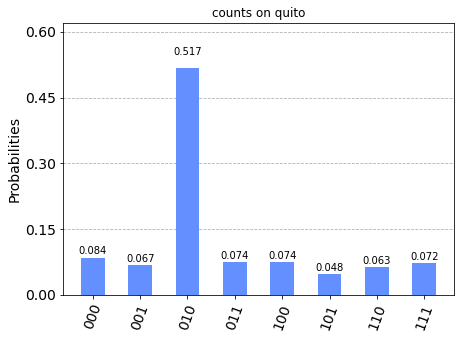

In [29]:
n = 3
m = 2
j = [0, 1]
h = [0,1,0]
res = DesignPartialGroverCircuit(n, m, j, h)
ClassicGroverStats(res, h, n)
# res.draw()

In [11]:
design_and_test_two_stage(3, 2, [1, 0], 2, [1, 0], [1, 0, 1], back)

P_theoretical:  0.4999999999999992
gates =  OrderedDict([('rz', 36), ('cx', 27), ('sx', 16), ('x', 2), ('barrier', 1), ('measure', 1)])
depth =  61
S:  0.9504761904761905
1024 499
P_actual:  48.73046875 %
P_theoretical:  0.624999999999999
gates =  OrderedDict([('rz', 36), ('cx', 27), ('sx', 16), ('x', 2), ('measure', 2), ('barrier', 1)])
depth =  61
S:  2.382775119617225
1024 498
P_actual:  48.6328125 %


(0.9504761904761905, 0.7583679199218775, 122, 514.7897079299161)

P_theoretical:  0.4999999999999991
gates =  OrderedDict([('rz', 37), ('cx', 27), ('sx', 16), ('x', 4), ('measure', 2), ('barrier', 1)])
depth =  61
S:  1.7413127413127414
1024 451
P_actual:  44.04296875 %


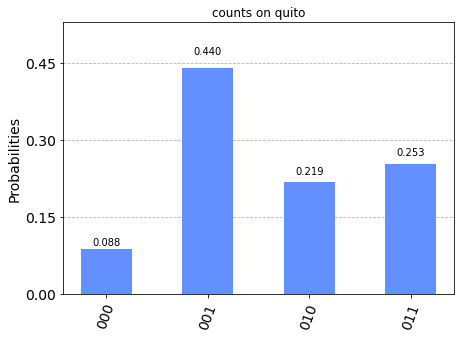

In [41]:
n = 3
m = 2
j = [1, 0]
h = [0,1,0]
partial_state = [0, 1]
res = design_partial_grover_circuit(n, m, j, h)
(_, _, _, _, a) = QPSA_stats(res, partial_state, n)
a

ibmqfactory.load_account:WARNING:2022-04-14 19:41:45,475: Credentials are already in use. The existing account in the session will be replaced.


{'0000': 0.015624999999999965, '0001': 0.01562499999999998, '0010': 0.39062499999999917, '0011': 0.01562499999999998, '0100': 0.015624999999999972, '0101': 0.015624999999999972, '0110': 0.015624999999999962, '0111': 0.015624999999999972, '1000': 0.015624999999999965, '1001': 0.01562499999999998, '1010': 0.39062499999999917, '1011': 0.01562499999999998, '1100': 0.015624999999999972, '1101': 0.015624999999999972, '1110': 0.015624999999999962, '1111': 0.015624999999999972}
P_theoretical:  0.8124999999999983
gates =  OrderedDict([('rz', 52), ('cx', 33), ('sx', 25), ('x', 3), ('measure', 2), ('barrier', 1)])
depth =  79
S:  4.074829931972789
1024 599
P_actual:  58.49609375 %


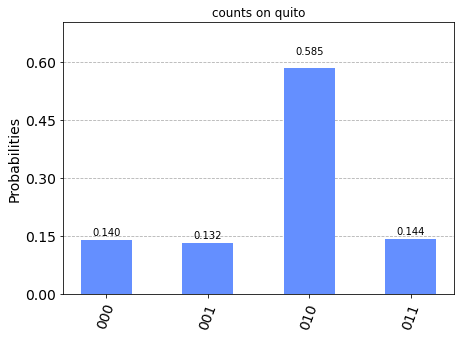

In [36]:
n = 3
m = 2
j = [0, 1]
h = [0,1,0]
partial_state = [1, 0]
res = design_partial_grover_circuit(n, m, j, h)
(_, _, _, a) = QPSA_stats(res, partial_state, n, False)
a

In [12]:
# run locally
sim = Aer.get_backend('aer_simulator')
# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grover_circuit_sim = grover_circuit.copy()
circ = transpile(grover_circuit_sim, sim)
result = sim.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Grover results')

MissingOptionalLibraryError: "The 'qiskit-aer' library is required to use 'Aer provider'. You can install it with 'pip install qiskit-aer'."

In [62]:
print(counts)

{'100': 792, '010': 28, '110': 40, '101': 33, '111': 32, '000': 35, '011': 36, '001': 28}


In [12]:
circ.draw()

┌───┐          ┌─────────┐      ┌───────────┐ ░ ┌─┐         
   q_0: ────┤ H ├──────■───┤ U2(0,0) ├───■──┤ U2(-π,-π) ├─░─┤M├─────────
         ┌──┴───┴──┐   │   ├─────────┴┐  │  ├───────────┤ ░ └╥┘┌─┐      
   q_1: ─┤ U2(0,0) ├───■───┤ U2(-π,0) ├──■──┤ U2(-π,-π) ├─░──╫─┤M├──────
         ├─────────┤   │  ┌┴──────────┤┌─┴─┐└─┬────────┬┘ ░  ║ └╥┘┌─┐   
   q_2: ─┤ U2(0,0) ├───■──┤ U3(π,0,0) ├┤ X ├──┤ U1(-π) ├──░──╫──╫─┤M├───
        ┌┴─────────┴┐┌─┴─┐└───────────┘└───┘  └────────┘  ░  ║  ║ └╥┘┌─┐
   q_3: ┤ U2(-π,-π) ├┤ X ├────────────────────────────────░──╫──╫──╫─┤M├
        └───────────┘└───┘                                ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════════════════════════╩══╩══╩══╩═
                                                             0  1  2  3

In [14]:
# the depth of our circuit heavily depends on the device topology and base operations we are allowed to use.
# In order to define this we will mock the Vigo device

from qiskit.test.mock import FakeVigo
fv = FakeVigo()
fv
# optimized_3 = transpile(grover_circuit, backend=fv, seed_transpiler=11, optimization_level=3)
# print('gates = ', optimized_3.count_ops())
# print('depth = ', optimized_3.depth())

<FakeVigo('fake_vigo')>

In [15]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [51]:
from qiskit.tools.jupyter import *
back = provider.get_backend("ibmq_quito")
optimized_3 = transpile(grover_circuit, backend=back, seed_transpiler=11, optimization_level=3)
print('gates = ', optimized_3.count_ops())
print('depth = ', optimized_3.depth())

gates =  OrderedDict([('rz', 20), ('sx', 12), ('cx', 11), ('x', 1)])
depth =  30


In [54]:
back

RequestsApiError: '403 Client Error: Forbidden for url: https://api.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/devices/ibmq_quito/queue/status. <!DOCTYPE html>\n<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->\n<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->\n<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->\n<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->\n<head>\n<title>Access denied | api.quantum-computing.ibm.com used Cloudflare to restrict access</title>\n<meta charset="UTF-8" />\n<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />\n<meta http-equiv="X-UA-Compatible" content="IE=Edge" />\n<meta name="robots" content="noindex, nofollow" />\n<meta name="viewport" content="width=device-width,initial-scale=1" />\n<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />\n\n\n<script>\n(function(){if(document.addEventListener&&window.XMLHttpRequest&&JSON&&JSON.stringify){var e=function(a){var c=document.getElementById("error-feedback-survey"),d=document.getElementById("error-feedback-success"),b=new XMLHttpRequest;a={event:"feedback clicked",properties:{errorCode:1009,helpful:a,version:1}};b.open("POST","https://sparrow.cloudflare.com/api/v1/event");b.setRequestHeader("Content-Type","application/json");b.setRequestHeader("Sparrow-Source-Key","c771f0e4b54944bebf4261d44bd79a1e");\nb.send(JSON.stringify(a));c.classList.add("feedback-hidden");d.classList.remove("feedback-hidden")};document.addEventListener("DOMContentLoaded",function(){var a=document.getElementById("error-feedback"),c=document.getElementById("feedback-button-yes"),d=document.getElementById("feedback-button-no");"classList"in a&&(a.classList.remove("feedback-hidden"),c.addEventListener("click",function(){e(!0)}),d.addEventListener("click",function(){e(!1)}))})}})();\n</script>\n\n<script defer src="https://api.radar.cloudflare.com/beacon.js"></script>\n</head>\n<body>\n  <div id="cf-wrapper">\n    <div class="cf-alert cf-alert-error cf-cookie-error hidden" id="cookie-alert" data-translate="enable_cookies">Please enable cookies.</div>\n    <div id="cf-error-details" class="p-0">\n      <header class="mx-auto pt-10 lg:pt-6 lg:px-8 w-240 lg:w-full mb-15 antialiased">\n         <h1 class="inline-block md:block mr-2 md:mb-2 font-light text-60 md:text-3xl text-black-dark leading-tight">\n           <span data-translate="error">Error</span>\n           <span>1009</span>\n         </h1>\n         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">Ray ID: 7018b6ae2b3875bb &bull;</span>\n         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">2022-04-25 17:14:11 UTC</span>\n        <h2 class="text-gray-600 leading-1.3 text-3xl lg:text-2xl font-light">Access denied</h2>\n      </header>\n\n      <section class="w-240 lg:w-full mx-auto mb-8 lg:px-8">\n          <div id="what-happened-section" class="w-1/2 md:w-full">\n            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_happened">What happened?</h2>\n            <p>The owner of this website (api.quantum-computing.ibm.com) has banned the country or region your IP address is in (RU) from accessing this website.</p>\n            \n          </div>\n\n          \n      </section>\n\n      <div class="feedback-hidden py-8 text-center" id="error-feedback">\n    <div id="error-feedback-survey" class="footer-line-wrapper">\n        Was this page helpful?\n        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-yes" type="button">Yes</button>\n        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-no" type="button">No</button>\n    </div>\n    <div class="feedback-success feedback-hidden" id="error-feedback-success">\n        Thank you for your feedback!\n    </div>\n</div>\n\n\n      <div class="cf-error-footer cf-wrapper w-240 lg:w-full py-10 sm:py-4 sm:px-8 mx-auto text-center sm:text-left border-solid border-0 border-t border-gray-300">\n  <p class="text-13">\n    <span class="cf-footer-item sm:block sm:mb-1">Cloudflare Ray ID: <strong class="font-semibold">7018b6ae2b3875bb</strong></span>\n    <span class="cf-footer-separator sm:hidden">&bull;</span>\n    <span class="cf-footer-item sm:block sm:mb-1"><span>Your IP</span>: 188.243.183.201</span>\n    <span class="cf-footer-separator sm:hidden">&bull;</span>\n    <span class="cf-footer-item sm:block sm:mb-1"><span>Performance &amp; security by</span> <a rel="noopener noreferrer" href="https://www.cloudflare.com/5xx-error-landing" id="brand_link" target="_blank">Cloudflare</a></span>\n    \n  </p>\n</div><!-- /.error-footer -->\n\n\n    </div><!-- /#cf-error-details -->\n  </div><!-- /#cf-wrapper -->\n\n  <script>\n  window._cf_translation = {};\n  \n  \n</script>\n\n</body>\n</html>\n'

<IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>

In [9]:
provider = IBMQ.save_account("43456020bee4d8426003db5dc03dd22613d52b46d72c444a55aa2729c8c5609789ef4535c06b9ea7156441c250347eb8695ca9eb3dd84c2e9726b3942e5b518c")

In [34]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

NameError: name 'least_busy' is not defined

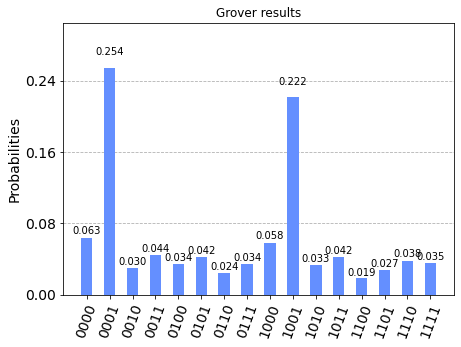

In [32]:
n = 3
grover_circuit = QuantumCircuit(n+1)
grover_circuit.x(3)
grover_circuit.h(3)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(Grover_operator(n, [1,0,0]), [0,1,2,3])
grover_circuit.measure_all()

result = execute(grover_circuit, fv).result()
counts = result.get_counts()
plot_histogram(counts, title='Grover results')

In [66]:
def AlgoStats(counts, state, n):
    m = len(state)
    strState = ''.join(str(e) for e in state)
    summ = 0;
    res = 0;
    max_ = 0;
    for strin in counts:
        summ += counts[strin]
        if strin == strState:
            res += counts[strin]
        else:
            if max_ < counts[strin]:
                max_ = counts[strin]
                
    Pactual = res/summ
    S = Pactual/max_
    print(summ, res)
    print(res*100/summ, "%")
    return (Pactual, S)

P_theoretical:  0.47265624999999867
gates =  OrderedDict([('rz', 123), ('cx', 85), ('sx', 59), ('x', 6), ('measure', 4), ('barrier', 1)])
depth =  179
S:  1.9213483146067416
1024 171
P_actual:  16.69921875 %


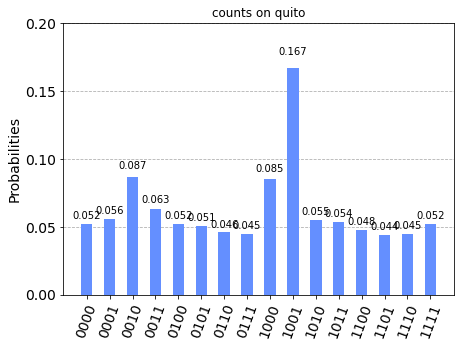

In [41]:
n = 4
h = [1,0,0,1]
grover_circuit = QuantumCircuit(n+1, 4)
grover_circuit = initialize_s(grover_circuit, [0,1,2,3])
grover_circuit.x(4)
grover_circuit.h(4)
grover_circuit.append(Grover_operator(n, h), [0,1,2,3,4])
grover_circuit.draw()
res = ClassicGroverStats(grover_circuit, h, n)
res

P_theoretical:  0.9084472656249958
gates =  OrderedDict([('rz', 244), ('cx', 193), ('sx', 121), ('x', 13), ('measure', 4), ('barrier', 1)])
depth =  383
S:  0.00123291015625
1024 101
P_actual:  9.86328125 %


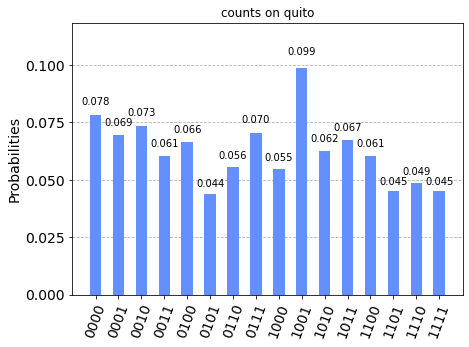

In [38]:
n = 4
h = [1,0,0,1]
grover_circuit = QuantumCircuit(n+1, 4)
grover_circuit = initialize_s(grover_circuit, [0,1,2,3])
grover_circuit.x(4)
grover_circuit.h(4)
grover_circuit.append(Grover_operator(n, h), [0,1,2,3,4])
grover_circuit.append(Grover_operator(n, h), [0,1,2,3,4])
grover_circuit.draw()
res = ClassicGroverStats(grover_circuit, h, n)
res

P_theoretical:  0.9613189697265565
gates =  OrderedDict([('rz', 342), ('cx', 298), ('sx', 160), ('x', 16), ('measure', 4), ('barrier', 1)])
depth =  558
S:  0.0008077739197530864
1024 67
P_actual:  6.54296875 %


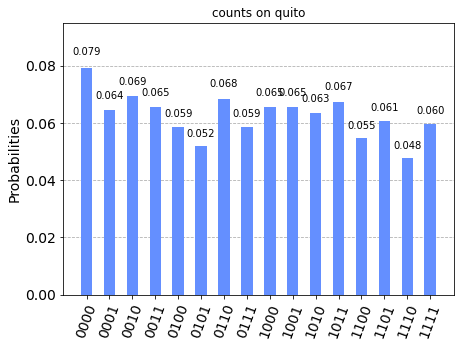

In [39]:
n = 4
h = [1,0,0,1]
grover_circuit = QuantumCircuit(n+1, 4)
grover_circuit = initialize_s(grover_circuit, [0,1,2,3])
grover_circuit.x(4)
grover_circuit.h(4)
grover_circuit.append(Grover_operator(n, h), [0,1,2,3,4])
grover_circuit.append(Grover_operator(n, h), [0,1,2,3,4])
grover_circuit.append(Grover_operator(n, h), [0,1,2,3,4])
grover_circuit.draw()
res = ClassicGroverStats(grover_circuit, h, n)
res

In [13]:
h=[0,0,1,1,0]
h[5-4:(5-4)+2]

[0, 1]

In [ ]:

# If you want this feature you should probably turn on VPN before executing this line
# it is not necessary to run this for tests

# provider = IBMQ.load_account()

In [ ]:
back = provider.get_backend("ibmq_quito")
simulator = Aer.get_backend('qasm_simulator').from_backend(back)

In [ ]:
# for this you need to load IBMQ account as provider
# first tests. Make sure you can successfully run those 
test = ThreeQubitCases(back, simulator)
test.D2M3()
test.D3M3()
test.D3D3M3()
test.D2M1_D2M2()
test.G1D2M2()